In [2]:
# 1. Pré-processamento
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# 2. Modelos avançados
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [6]:
import pandas as pd
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split, cross_validate


In [4]:
credentials = service_account.Credentials.from_service_account_file(
    "credentials.json"
)

client = bigquery.Client("brasil-aberto-443222", credentials=credentials)

In [5]:
query = """
with enem as (
select
    enem.`CO_MUNICIPIO_ESC`, enem.`Q006`,
    avg(`NU_NOTA_CH`
    + `NU_NOTA_CN`
    + `NU_NOTA_LC`
    + `NU_NOTA_MT`
    + `NU_NOTA_REDACAO`) as nota_media,
from `brasil-aberto-443222.microdados_abertos.enem` as enem
where
    `NU_NOTA_CH`
    + `NU_NOTA_CN`
    + `NU_NOTA_LC`
    + `NU_NOTA_MT`
    + `NU_NOTA_REDACAO`
    > 0
    and enem.`IN_TREINEIRO` != 1
    and enem.`CO_MUNICIPIO_ESC` is not null
group by enem.`CO_MUNICIPIO_ESC`, enem.`Q006`
)

select
  enem.`Q006`,
  enem.nota_media,
  ips.pop,
  ips.pib_pc,
  -- Nutrição e Cuidados Médicos Básicos
  ips.cv_polio,
  ips.hcsap,
  ips.macsap,
  ips.mi5,
  ips.subnutricao,
  -- Abastecimento e Esgotamento
  ips.aavrd,
  ips.esa,
  ips.iaa,
  ips.ipad,
  -- Moradia
  ips.dcra,
  ips.diea,
  ips.dpa,
  ips.dpsa,
  -- Segurança Pessoal
  ips.aj,
  ips.am,
  ips.homicidios,
  ips.mat,
  -- Acesso ao Conhecimento Básico
  ips.aef,
  ips.aem,
  ips.eem,
  ips.disem,
  ips.ideb_ef,
  ips.ref,
  -- Acesso à Informação e Comunicação
  ips.cim,
  ips.di_blf,
  ips.dtm,
  ips.qim,
  -- Saúde e Bem-estar
  ips.ev,
  ips.m15_50,
  ips.mdcnt,
  ips.obesidade,
  ips.suicidios,
  -- Qualidade do Meio Ambiente
  ips.avu,
  ips.eco2h,
  ips.fc,
  ips.ivcm,
  ips.svps,
  -- Direitos Individuais
  ips.apdh,
  ips.eadmn,
  ips.iadj,
  ips.tclp,
  -- Liberdades Individuais e de Escolha
  ips.acle,
  ips.ga19,
  ips.ppau,
  ips.ti,
  -- Inclusão Social
  ips.pgcm,
  ips.pnpcm,
  ips.vci,
  ips.vcn,
  ips.vcm,
  -- Acesso à Educação Superior
  ips.ees,
  ips.mees
from enem
inner join `brasil-aberto-443222.microdados_abertos.municipios_ips` as ips
    on (
        ips.codigo = cast(enem.`CO_MUNICIPIO_ESC` as string)
    )
"""

municipalities_df = client.query(query).to_dataframe()
municipalities_df.head()

,Q006,nota_media,pop,pib_pc,cv_polio,hcsap,macsap,mi5,subnutricao,aavrd,...,ga19,ppau,ti,pgcm,pnpcm,vci,vcn,vcm,ees,mees
0,D,2565.800000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
1,A,1947.100000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
2,B,2382.941667,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
3,C,2844.300000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
4,F,2703.800000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883


In [7]:
dfs = {}
for renda, grupo in municipalities_df.groupby('Q006'):
    dfs[renda] = grupo

models = {}
results = {}

for faixa_de_renda in dfs.keys():
    print(f"\nProcessando faixa de renda: {faixa_de_renda}")
    
    df = dfs[faixa_de_renda].copy()
    
    # Remover outliers na variável alvo
    q1 = df['nota_media'].quantile(0.01)
    q3 = df['nota_media'].quantile(0.99)
    df = df[(df['nota_media'] >= q1) & (df['nota_media'] <= q3)]
    
    X = df.drop(columns=["Q006", "nota_media"])
    y = df["nota_media"]
    
    # Tratar valores ausentes
    X = X.fillna(X.median())
    
    # Pipeline para features numéricas
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', RobustScaler())
    ])
    
    # Aplicar transformações
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, X.columns)]
    )
    
    # Dividir em treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Comparar diferentes modelos
    models_to_test = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'LASSO': LassoCV(cv=5, random_state=42),
        'Ridge': RidgeCV(cv=5)
    }
    
    model_results = {}
    
    for name, model in models_to_test.items():
        # Criar pipeline completo
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Validação cruzada
        cv_scores = cross_validate(pipe, X, y, cv=5, scoring='r2', return_estimator=True)
        
        # Treinar modelo final
        pipe.fit(X_train, y_train)
        test_score = pipe.score(X_test, y_test)
        
        print(f"Modelo {name}:")
        print(f"  CV R² médio: {cv_scores['test_score'].mean():.4f} ± {cv_scores['test_score'].std():.4f}")
        print(f"  R² no teste: {test_score:.4f}")
        
        model_results[name] = {
            'cv_scores': cv_scores['test_score'],
            'test_score': test_score,
            'model': pipe
        }
    
    # Escolher o melhor modelo
    best_model = max(model_results.items(), key=lambda x: x[1]['test_score'])
    print(f"\nMelhor modelo para faixa {faixa_de_renda}: {best_model[0]}")
    
    # Salvar resultados
    results[faixa_de_renda] = model_results
    models[faixa_de_renda] = best_model[1]['model']
    
    # Para o melhor modelo, analisar feature importance
    if hasattr(best_model[1]['model']['model'], 'feature_importances_'):
        importances = best_model[1]['model']['model'].feature_importances_
        feature_names = X.columns
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 features mais importantes:")
        print(importance_df.head(10))


Processando faixa de renda: A
Modelo RandomForest:
  CV R² médio: 0.0526 ± 0.0533
  R² no teste: 0.1277
Modelo GradientBoosting:
  CV R² médio: 0.0397 ± 0.0633
  R² no teste: 0.1195
Modelo LASSO:
  CV R² médio: 0.0650 ± 0.0488
  R² no teste: 0.1140
Modelo Ridge:
  CV R² médio: 0.0497 ± 0.0469
  R² no teste: 0.1098

Melhor modelo para faixa A: RandomForest

Top 10 features mais importantes:
        feature  importance
44         ga19    0.089901
29           ev    0.029564
13          dpa    0.028472
8           esa    0.026834
14         dpsa    0.025939
0           pop    0.025596
30       m15_50    0.023580
26       di_blf    0.022170
6   subnutricao    0.021176
28          qim    0.021013

Processando faixa de renda: B
Modelo RandomForest:
  CV R² médio: 0.1058 ± 0.0491
  R² no teste: 0.1888
Modelo GradientBoosting:
  CV R² médio: 0.1012 ± 0.0561
  R² no teste: 0.1900
Modelo LASSO:
  CV R² médio: 0.1051 ± 0.0441
  R² no teste: 0.1976
Modelo Ridge:
  CV R² médio: 0.0925 ± 0.0572
  R

KeyboardInterrupt: 

In [13]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_validate, train_test_split

from matplotlib import pyplot as plt
from tqdm import tqdm

In [15]:
# Unificar os dados e criar a nova variável alvo (diferença da média por faixa de renda)
df_unified = municipalities_df.copy()

# Calcular quanto cada município supera/fica abaixo da média de sua faixa de renda
df_unified['nota_diff'] = df_unified['nota_media'] - df_unified.groupby('Q006')['nota_media'].transform('mean')

# Verificar a distribuição da nova variável alvo
print("Estatísticas da variável 'nota_diff':")
print(df_unified['nota_diff'].describe())


# Criar dummies para a variável categórica de renda
df_unified = pd.get_dummies(df_unified, columns=['Q006'], prefix='renda')


# Definir features e target
X = df_unified.drop(columns=["nota_media", "nota_diff"])
y = df_unified["nota_diff"]

# Pré-processamento de dados


# Pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Aplicar transformações
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, X.columns)]
)

# Dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Comparar diferentes modelos
models_to_test = {
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'LASSO': LassoCV(cv=5, random_state=42),
    'Ridge': RidgeCV(cv=5)
}

model_results = {}

for name, model in tqdm(models_to_test.items(), desc="Testando modelos"):
    # Criar pipeline completo
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    print(f"\nValidação cruzada para {name}...")
    # Validação cruzada
    cv_scores = cross_validate(pipe, X, y, cv=5, scoring='r2', return_estimator=True)
    print(f"  CV R² médio: {cv_scores['test_score'].mean():.4f} ± {cv_scores['test_score'].std():.4f}")
    
    # Treinar modelo final
    print(f"Treinando modelo {name}...")
    pipe.fit(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    print(f"  R² no teste: {test_score:.4f}")
    
    model_results[name] = {
        'cv_scores': cv_scores['test_score'],
        'test_score': test_score,
        'model': pipe
    }

# Escolher o melhor modelo
best_model_name = max(model_results.items(), key=lambda x: x[1]['test_score'])[0]
best_model = model_results[best_model_name]['model']
print(f"\nMelhor modelo: {best_model_name} com R² de {model_results[best_model_name]['test_score']:.4f}")

# Para o melhor modelo, analisar feature importance
if hasattr(best_model['model'], 'feature_importances_'):
    importances = best_model['model'].feature_importances_
    feature_names = X.columns
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 features mais importantes:")
    print(importance_df.head(15))
    
    # Visualização das feature importances
    plt.figure(figsize=(12, 10))
    plt.barh(importance_df['feature'].head(15), importance_df['importance'].head(15))
    plt.xlabel('Importância')
    plt.title('Top 15 Features Mais Importantes')
    plt.gca().invert_yaxis()  # Para ter a feature mais importante no topo
    plt.tight_layout()
    plt.show()

Estatísticas da variável 'nota_diff':
count    4.124600e+04
mean     7.638291e-14
std      3.152357e+02
min     -2.345932e+03
25%     -1.669090e+02
50%      3.404472e+01
75%      1.957366e+02
max      1.310330e+03
Name: nota_diff, dtype: float64


Testando modelos:   0%|          | 0/4 [00:00<?, ?it/s]


Validação cruzada para RandomForest...
  CV R² médio: 0.0903 ± 0.0181
Treinando modelo RandomForest...


Testando modelos:   0%|          | 0/4 [12:10<?, ?it/s]


KeyboardInterrupt: 

In [17]:
import seaborn as sns

Características que mais diferenciam municípios de alto e baixo desempenho:
        Abaixo da média  Acima da média  Diferença %
pop        17764.469643    39573.749757   122.769103
fc            41.754593        9.069046   -78.280125
eco2h         29.742907       11.205929   -62.324027
di_blf        12.614516       17.902175     41.91725
vci          142.994484      202.046669    41.296827
acle           3.220024         4.52734    40.599586
ti            13.304733        8.330602   -37.386178
vcm          204.630442      268.320662    31.124509
esa           50.906274         65.8807    29.415678
svps          13.172639         9.69145   -26.427425
avu            2.890247        3.611907     24.96878
ga19          16.033879       12.610001   -21.354021
eadmn          2.181465        2.635921    20.832647
aef            1.321969        1.047056   -20.795706
ppau            2.83762        3.381735     19.17505


/var/folders/7t/zb7nczls5zd_sj1xkjchy15w0000gn/T/ipykernel_11959/1250591179.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/var/folders/7t/zb7nczls5zd_sj1xkjchy15w0000gn/T/ipykernel_11959/1250591179.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/var/folders/7t/zb7nczls5zd_sj1xkjchy15w0000gn/T/ipykernel_11959/1250591179.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/var/folders/7t/zb7nczls5zd_sj1xkjchy15w0000gn/T/ipykernel_11959/1250591179.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/var/folders/7t/zb7nczls5zd_sj1xkjchy15w0000gn/T/ipykernel_11959/1250591179.py:4

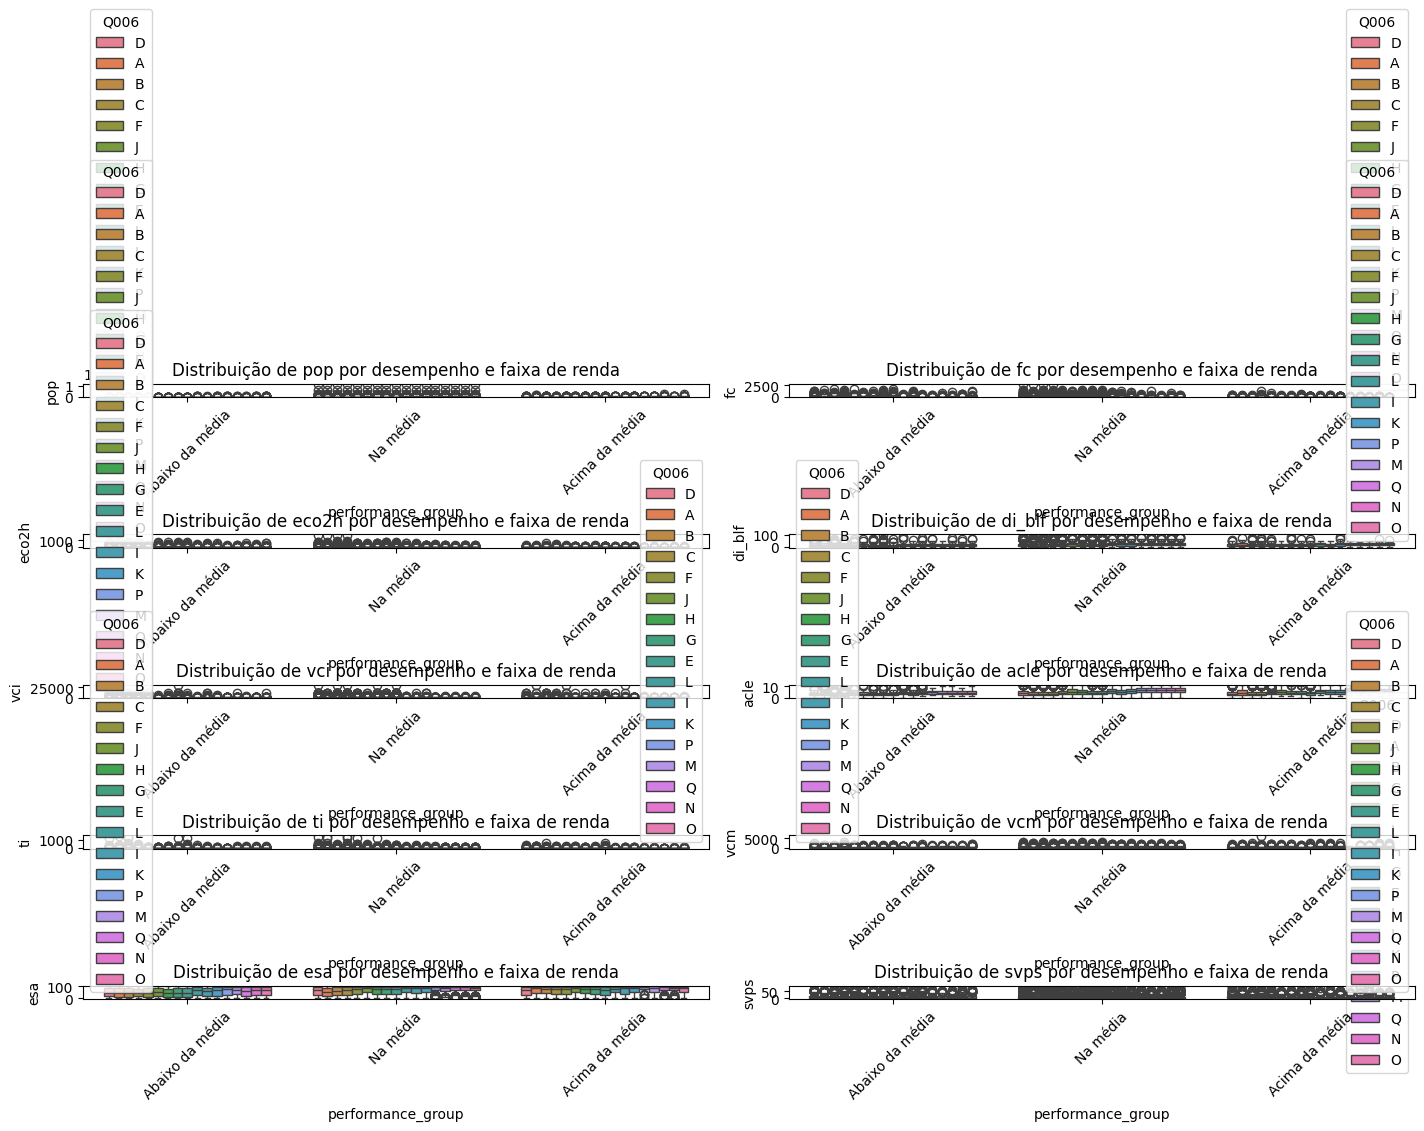

In [18]:
# 1. Identificar municípios com desempenho significativamente acima/abaixo da média em sua faixa
df_unified = municipalities_df.copy()
df_unified['nota_diff'] = df_unified['nota_media'] - df_unified.groupby('Q006')['nota_media'].transform('mean')
df_unified['z_score'] = df_unified.groupby('Q006')['nota_diff'].transform(lambda x: (x - x.mean()) / x.std())

# Classificar municípios em grupos de desempenho
df_unified['performance_group'] = pd.cut(
    df_unified['z_score'], 
    bins=[-float('inf'), -1, 1, float('inf')],
    labels=['Abaixo da média', 'Na média', 'Acima da média']
)

# 2. Analisar características distintivas de cada grupo
comparison = pd.DataFrame()

for group in ['Abaixo da média', 'Na média', 'Acima da média']:
    group_stats = df_unified[df_unified['performance_group'] == group].drop(
        columns=['nota_media', 'nota_diff', 'z_score', 'performance_group', 'Q006']
    ).mean()
    comparison[group] = group_stats

# Calcular diferenças percentuais entre grupos extremos
comparison['Diferença %'] = ((comparison['Acima da média'] / comparison['Abaixo da média']) - 1) * 100

# Ordenar por diferença percentual absoluta
comparison_sorted = comparison.sort_values('Diferença %', key=abs, ascending=False)

print("Características que mais diferenciam municípios de alto e baixo desempenho:")
print(comparison_sorted[['Abaixo da média', 'Acima da média', 'Diferença %']].head(15))

# 3. Visualizar os indicadores mais distintivos por faixa de renda
plt.figure(figsize=(14, 10))
top_indicators = comparison_sorted.index[:10]  # Top 10 indicadores mais distintos

for i, indicator in enumerate(top_indicators):
    plt.subplot(5, 2, i+1)
    sns.boxplot(x='performance_group', y=indicator, hue='Q006', data=df_unified)
    plt.title(f'Distribuição de {indicator} por desempenho e faixa de renda')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

In [22]:
# Unificar os dados
df_unified = municipalities_df.copy()

# Calcular a diferença em relação à média da faixa de renda
df_unified['nota_diff'] = df_unified['nota_media'] - df_unified.groupby('Q006')['nota_media'].transform('mean')

# Transformar em variável binária
# 1 = desempenho acima da média para a faixa de renda
# 0 = desempenho abaixo da média para a faixa de renda
df_unified['above_average'] = (df_unified['nota_diff'] > 0).astype(int)

# Converter Q006 para variáveis dummy
df_unified = pd.get_dummies(df_unified, columns=['Q006'], prefix='renda')

# Definir features e target
X = df_unified.drop(columns=["nota_media", "nota_diff", "above_average"])
y = df_unified["above_average"]

# Dividir em treino/teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Testar modelos de classificação
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Treinar modelo
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

# Validação cruzada
cv_scores = cross_val_score(rf_clf, X, y, cv=5, scoring='accuracy')
print(f"Acurácia média na validação cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Avaliar no conjunto de teste
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])

print(f"Métricas no conjunto de teste:")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Analisar feature importance
importances = rf_clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 15 features mais importantes:")
print(importance_df.head(15))

Acurácia média na validação cruzada: 0.5803 ± 0.0400
Métricas no conjunto de teste:
Acurácia: 0.6721
Precisão: 0.6951
Recall: 0.7171
F1-Score: 0.7059
AUC-ROC: 0.7328

Top 15 features mais importantes:
    feature  importance
55  renda_B    0.048542
56  renda_C    0.047711
57  renda_D    0.045634
58  renda_E    0.041775
60  renda_G    0.037013
54  renda_A    0.036804
59  renda_F    0.036484
0       pop    0.029939
61  renda_H    0.029723
62  renda_I    0.025533
63  renda_J    0.022857
43     acle    0.021535
35    eco2h    0.021384
64  renda_K    0.020192
44     ga19    0.020109


In [23]:
# Criar um modelo sem as variáveis de renda para focar nas outras features
X_no_income = X.drop(columns=[col for col in X.columns if 'renda_' in col])
rf_clf_no_income = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf_no_income.fit(X_train.drop(columns=[col for col in X.columns if 'renda_' in col]), 
                     y_train)

# Analisar feature importance sem o efeito da renda
importances_no_income = rf_clf_no_income.feature_importances_
feature_names_no_income = X_no_income.columns
importance_df_no_income = pd.DataFrame({
    'feature': feature_names_no_income,
    'importance': importances_no_income
}).sort_values('importance', ascending=False)

print("Top 15 features mais importantes (excluindo renda):")
print(importance_df_no_income.head(15))

Top 15 features mais importantes (excluindo renda):
        feature  importance
0           pop    0.062407
43         acle    0.048461
35        eco2h    0.046544
44         ga19    0.042416
25          cim    0.029289
26       di_blf    0.028023
34          avu    0.023990
36           fc    0.023979
27          dtm    0.023878
8           esa    0.022421
29           ev    0.022130
52          ees    0.021554
14         dpsa    0.019091
6   subnutricao    0.018706
1        pib_pc    0.017555


In [24]:
from sklearn.inspection import permutation_importance

# Calcular permutation importance no conjunto de teste
result = permutation_importance(rf_clf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
}).sort_values('importance', ascending=False)

print("Top 15 features por Permutation Importance:")
print(perm_importance.head(15))

Top 15 features por Permutation Importance:
    feature  importance       std
0       pop    0.005164  0.002541
54  renda_A    0.003745  0.001025
56  renda_C    0.003455  0.001395
57  renda_D    0.002194  0.001542
58  renda_E    0.001976  0.001427
59  renda_F    0.001758  0.000730
60  renda_G    0.001721  0.001092
61  renda_H    0.001285  0.001141
50      vcn    0.001055  0.000950
55  renda_B    0.000994  0.001219
62  renda_I    0.000970  0.000711
65  renda_L    0.000958  0.000461
22    disem    0.000933  0.001168
64  renda_K    0.000885  0.000563
63  renda_J    0.000824  0.000672


In [ ]:
import shap

# Calcular SHAP values
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)

# Resumo visual dos SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detalhes por feature
for feature in importance_df_no_income['feature'].head(5):
    shap.dependence_plot(feature, shap_values, X_test)